In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Reading Data

In [5]:
fn = '../data/USvideos.csv'
df = pd.read_csv(fn, index_col='video_id')
df.head()

,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
video_id,,,,,,,,,,,,,,,
2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [6]:
del df['thumbnail_link']

# Cleaning Data

### Fixing time stamps
Trending data and publishing times are not in the date-time data format. Let's fix this first!

In [7]:
# Dates can be kept as dates
df['trending_date'] = pd.to_datetime(df['trending_date'],format='%y.%d.%m')
df['publish_time'] = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

df.insert(4, 'publish_date', df['publish_time'].dt.date)
df['publish_time'] = df['publish_time'].dt.time

In [8]:
print(df[['publish_date', 'publish_time']].head())

            publish_date publish_time
video_id                             
2kyS6SvSYSE   2017-11-13     17:13:01
1ZAPwfrtAFY   2017-11-13     07:30:00
5qpjK5DgCt4   2017-11-12     19:05:24
puqaWrEC7tY   2017-11-13     11:00:04
d380meD0W0M   2017-11-12     18:01:41


This looks good! Maybe there is a link between the time a video is published, and how much viewership it gets. Let's keep this in mind.

In [9]:
#discretise times to the nearest hour
df['publish_hour'] = df['publish_time'].apply(lambda t: t.hour+t.minute//30.0)

In [10]:
df['trending_date'] = df['trending_date'].dt.date

In [11]:
df['time_to_trend'] = df['trending_date']-df['publish_date']

### Introducing category column

In [12]:
type_int_list = ['views', 'likes', 'dislikes', 'comment_count']

# Make sure that these columns are treated as integers
for column in type_int_list:
    df[column] = df[column].astype(int)

# Category IDs need to be strings for json
type_str_list = ['category_id']
for column in type_str_list:
    df[column] = df[column].astype(str)
    
import json

# prepare a dictionary for converting ID to category
id_to_category = {}
with open('../data/US_category_id.json','r') as fp:
    data = json.load(fp)
    for category in data['items']:
        id_to_category[category['id']] = category['snippet']['title']

df.insert(4, 'category', df['category_id'].map(id_to_category))

In [13]:
print(df[['category_id', 'category']].head())

            category_id        category
video_id                               
2kyS6SvSYSE          22  People & Blogs
1ZAPwfrtAFY          24   Entertainment
5qpjK5DgCt4          23          Comedy
puqaWrEC7tY          24   Entertainment
d380meD0W0M          24   Entertainment


# Preliminary Analysis
Correlation between time when content is published and popularity

/Users/Petrichor/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


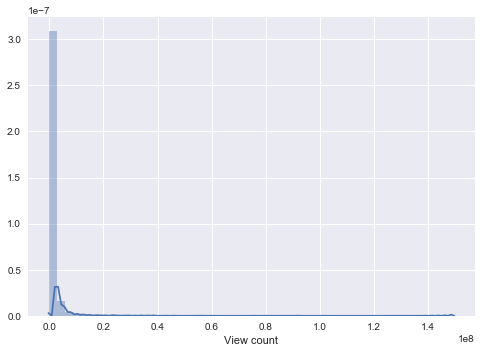

In [14]:
sns.distplot(df['views'],bins=50)
plt.xlabel("View count")
plt.show()

/Users/Petrichor/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


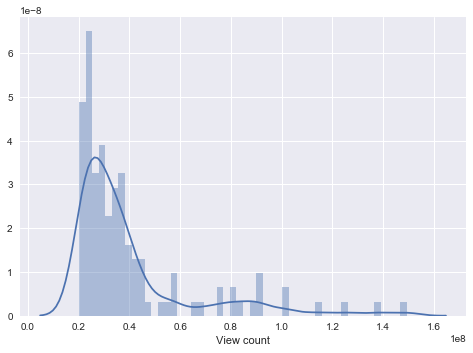

In [15]:
sns.distplot(df['views'][df['views']>0.2E8],bins=50)
plt.xlabel("View count")
plt.show()

Clearly there is a "super popular" category with a lot of views, and a very long tail of "less viewed" videos. It might help to categorise them in those bins

/Users/Petrichor/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


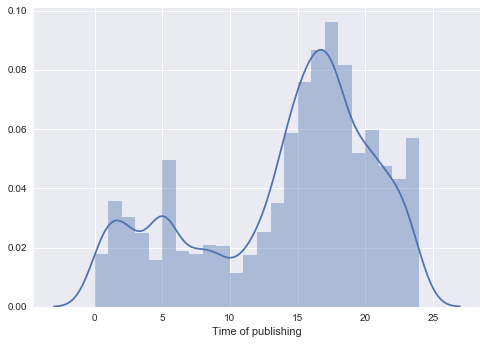

In [16]:
sns.distplot(df['publish_hour'],bins=24)
plt.xlabel("Time of publishing")
plt.show()

There are more videos being published past 11AM, and less in the early morning.

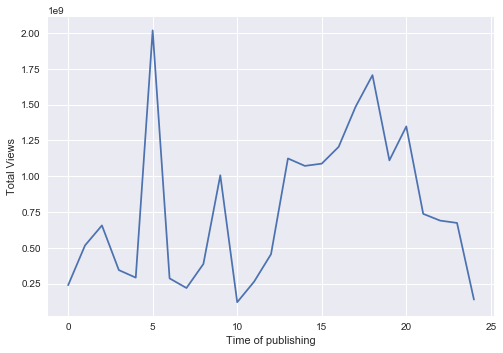

In [17]:
pubhr_group = df.groupby('publish_hour')
plt.plot(pubhr_group.apply(lambda gr: gr['views'].sum()),'-')
plt.xlabel('Time of publishing')
plt.ylabel('Total Views')
plt.show()

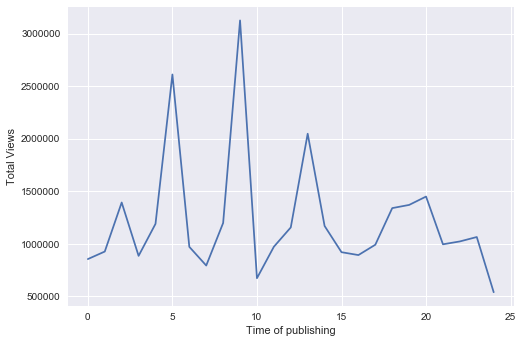

In [18]:
plt.plot(pubhr_group.apply(lambda gr: gr['views'].mean()),'-')
plt.xlabel('Time of publishing')
plt.ylabel('Total Views')
plt.show()

There is no clear trend between views and the time it is published. This indicates that successful videos tend to "live" longer, and the time it is published is immaterial.

In [19]:
df['time_to_trend'].describe()

count                       15593
mean      30 days 12:25:54.235875
std      231 days 18:20:33.738286
min               0 days 00:00:00
25%               2 days 00:00:00
50%               4 days 00:00:00
75%               6 days 00:00:00
max            3566 days 00:00:00
Name: time_to_trend, dtype: object

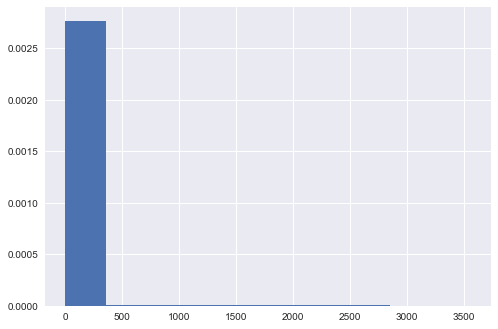

In [20]:
trend_time = df['time_to_trend'].apply(lambda d: d.days)
plt.hist(trend_time,normed=True)
plt.show()

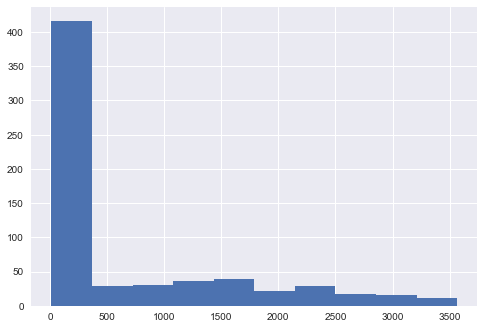

In [21]:
plt.hist(trend_time[trend_time>10])
plt.show()

### Correlations between popularity metrics
There might be a better way to quantify popularity. First let us check correlations between popularity metrics.

In [22]:
df['time_to_trend'] = df['time_to_trend'].apply(lambda d: d.days)
keep_columns = ['views', 'likes', 'dislikes', 'comment_count', 'time_to_trend', 'publish_hour'] # only looking at correlations between these variables
corr_matrix = df[keep_columns].corr()
print(corr_matrix)

                  views     likes  dislikes  comment_count  time_to_trend  \
views          1.000000  0.870324  0.573170       0.625791      -0.028744   
likes          0.870324  1.000000  0.499474       0.717343      -0.031871   
dislikes       0.573170  0.499474  1.000000       0.863248      -0.008435   
comment_count  0.625791  0.717343  0.863248       1.000000      -0.017906   
time_to_trend -0.028744 -0.031871 -0.008435      -0.017906       1.000000   
publish_hour  -0.025711 -0.016839  0.014451       0.007075       0.009665   

               publish_hour  
views             -0.025711  
likes             -0.016839  
dislikes           0.014451  
comment_count      0.007075  
time_to_trend      0.009665  
publish_hour       1.000000  


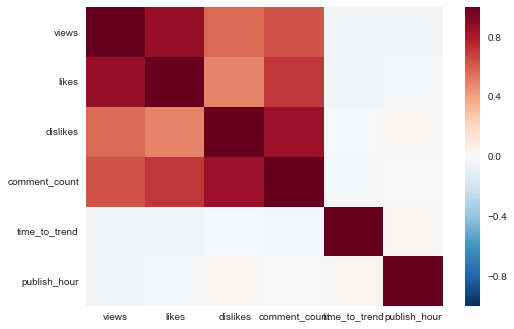

In [23]:
sns.heatmap(df[keep_columns].corr())
plt.show()

In [24]:
keep_columns = ['views', 'likes', 'dislikes', 'comment_count']

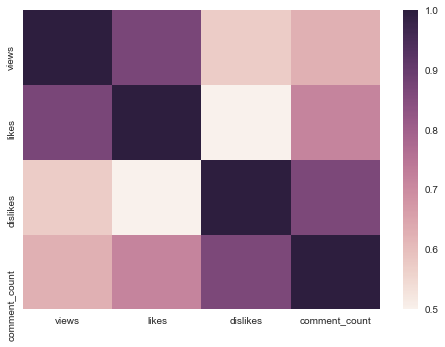

In [25]:
sns.heatmap(df[keep_columns].corr())
plt.show()

Strong correlations between:
Dislike/Comments, 
Like/Comments, 
Likes/Views

Let's understand what makes the top videos popular.

In [26]:
def visualize_most(df, column, num=10): # getting the top 10 videos by default
    sorted_df = df.sort_values(column, ascending=False).iloc[:num]
    
    ax = sorted_df[column].plot.bar()
    
    labels = []
    for item in sorted_df['title']:
        labels.append(item[:10] + '...')
    ax.set_xticklabels(labels, rotation=45, fontsize=10)
    
    plt.show()

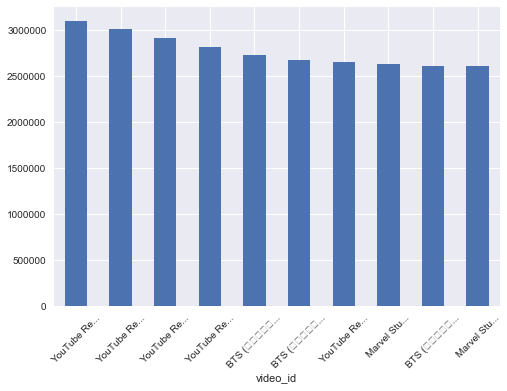

In [29]:
visualize_most(df,'likes',num=10)

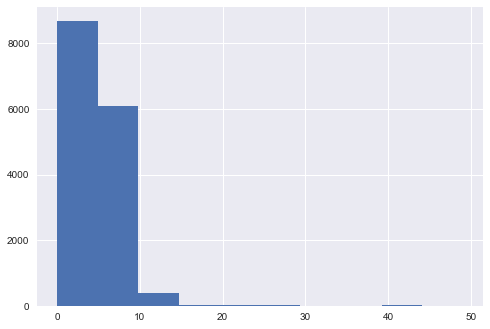

In [30]:
plt.hist(trend_time[trend_time<50])
plt.show()

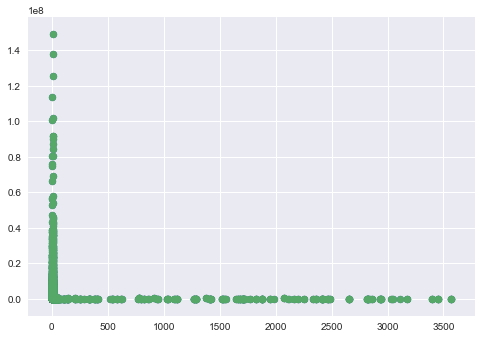

In [34]:
plt.scatter(trend_time, df['views'])
plt.show()

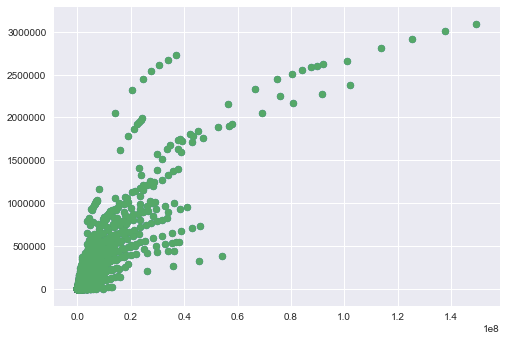

In [36]:
plt.scatter(df['views'],df['likes'])
plt.show()